In [138]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8-whitegrid")

from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import KFold

# Loading data

In [99]:
IMG_FOLDER = Path("/home/jpsrocha/Documents/Data/FEI_faces_norm/")
IMG_FILES = sorted(IMG_FOLDER.glob("*jpg"))
FIG_FOLDER = Path("../res/ML_Exercises/GB500/exercise_list_3/report/figures/")

imgs = []

for img in IMG_FILES:
    imgs.append(plt.imread(img).reshape(1, -1))  # Loading and reshaping

X = np.vstack(imgs)

del imgs  # Deleting images to save space

Y = np.array([1 if path.name.split(".")[0][-1] == "b" else 0 for path in IMG_FILES])

# Exploring DPCA

In [100]:
pca = PCA(150)
X_pca = pca.fit_transform(X)

In [101]:
svm = LinearSVC().fit(X_pca, Y)

In [29]:
pca.components_.shape

(150, 31266)

In [102]:
sorted_idx = np.flip(np.argsort(np.abs(svm.coef_)))

pca.components_ = pca.components_[sorted_idx.ravel(), :]

In [103]:
X_dpca = pca.transform(X)

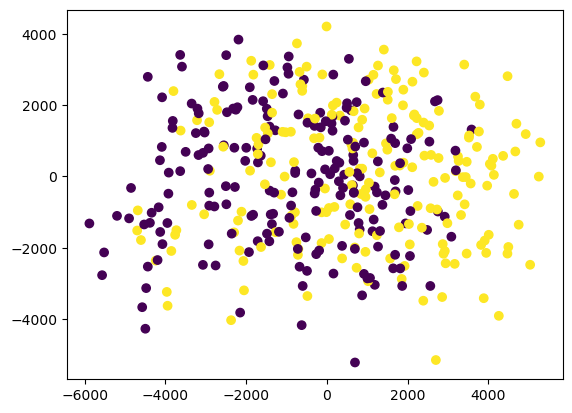

In [105]:
plt.scatter(X_pca[:, 1], X_pca[:, 2], c=Y) 

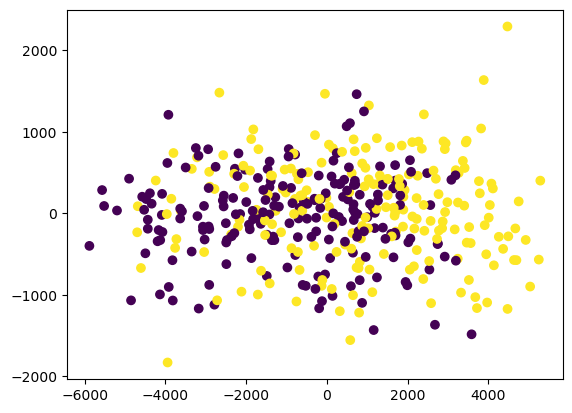

In [106]:
plt.scatter(X_dpca[:, 1], X_dpca[:, 2], c=Y) 

# DPCA class

Let's define a class in order to be able to use DPCA inside a pipeline.

In [107]:
class DPCA:

    def __init__(self, n_components):
        self.pca = PCA(n_components=n_components)

    def fit(self, X, Y):

        # Start fitting
        X_pca = self.pca.fit_transform(X)
        svm = LinearSVC().fit(X_pca, Y)

        # Sorting PCA components
        sorted_idx = np.flip(np.argsort(np.abs(svm.coef_)))
        self.pca.components_ = self.pca.components_[sorted_idx.ravel(), :]

    
    def transform(self, X):
        return self.pca.transform(X)


    def fit_transform(self, X, Y):
        self.fit(X, Y)
        return self.pca.transform(X)
        
        
        

In [109]:
model = make_pipeline(
    DPCA(150),
    LinearSVC()
)

In [112]:
model.fit(X, Y)

Pipeline(steps=[('dpca', <__main__.DPCA object at 0x7c0f8dba5550>),
                ('linearsvc', LinearSVC())])

In [116]:
accuracy_score(model.predict(X), Y)

1.0

# K-Fold cross validation

Let's reuse our testing code!

In [133]:
def model_b_factory():
    return make_pipeline(
        DPCA(150),
        SVC(kernel="sigmoid")
    )

def kf_classifier_cross_val(model_factory, X, Y, k=4, plot_filename=None) -> tuple[float, float]:
    """Function to make cross validation reutilizable"""

    # Starting auxiliar variables
    kf = KFold(k, random_state=42, shuffle=True)
    models = []
    accuracies = []

    if plot_filename:
        fig, axes = plt.subplots(nrows=2, ncols=2)
        

    # Training on each fold
    for i, (train_i, test_i) in enumerate(kf.split(X, Y), start=1):
        
        models.append(
            model_factory().fit(X[train_i], Y[train_i])
        )
        
        accuracies.append(models[-1].score(X[test_i], Y[test_i]))

        # Plot if necessary
        if plot_filename:
            ax = axes.ravel()[i-1]
            ConfusionMatrixDisplay(confusion_matrix(models[-1].predict(X[test_i]), Y[test_i])).plot(ax=ax)
            ax.set_title(f"K={i}")
            ax.grid(False)
        

        
    if plot_filename:
        plt.tight_layout()
        plt.savefig(FIG_FOLDER / plot_filename, dpi=100)
        plt.show()
        
        
    return np.mean(accuracies).item(), np.std(accuracies).item(), accuracies

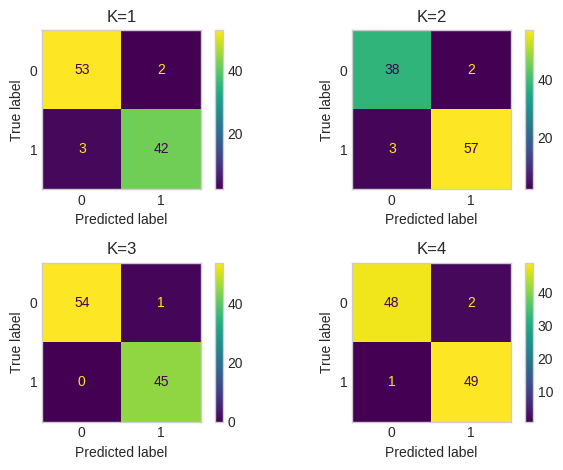

In [134]:
mu, std, acc_b = kf_classifier_cross_val(model_b_factory, X, Y, plot_filename="q3_b_cross_val.png")

In [139]:
mu, std, acc_b

(0.9649999999999999, 0.016583123951777013, [0.95, 0.95, 0.99, 0.97])

In [141]:
acc_a =  [0.95, 0.97, 0.99, 0.96]

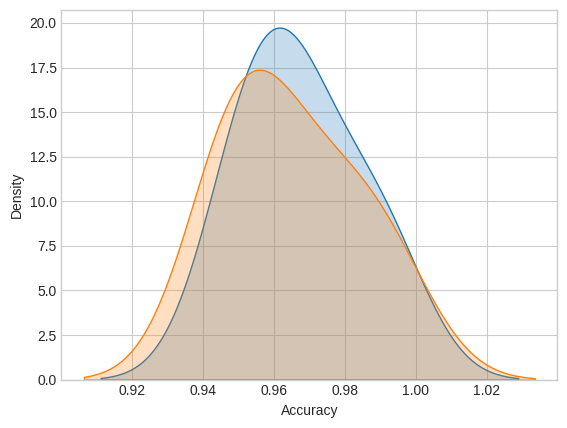

In [145]:
ax = sns.kdeplot(acc_a, label="Configuration (a)", fill=True)
sns.kdeplot(acc_b, label="Configuration (b)", ax=ax, fill=True)

ax.set(xlabel="Accuracy")

plt.savefig(FIG_FOLDER / "q3c_kde.png", dpi=100)